In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from pymoo.factory import get_performance_indicator

#
# Helper functions
#

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)


def get_early_stop(epoch_data, key='hv'):
    assert key in ['hv', 'score', 'last']
    if key == 'hv':
        best_hv = 0
        best_idx = None
        for e in natural_sort(epoch_data.keys()):
            if 'epoch' in e and 'loss' in epoch_data[e]:
                hv = epoch_data[e]['loss']['hv']
                if hv > best_hv:
                    best_hv = hv
                    best_idx = e
        return best_idx
    elif key == 'score':
        min_score = 1e15
        min_epoch = -1
        for e in natural_sort(epoch_data.keys()):
            if 'scores' in epoch_data[e]:
                s = epoch_data[e]['scores'][0]
                s = s[epoch_data[e]['task']]

                if s < min_score:
                    min_score = s
                    min_epoch = e

        return int(min_epoch.replace('epoch_', ''))
    elif key == 'last':
        last_epoch = natural_sort(epoch_data.keys())[-1]
        return int(last_epoch.replace('epoch_', ''))


def load_files(paths):
    contents = []
    for p in paths:
        with p.open(mode='r') as json_file:
            contents.append(json.load(json_file))
    return contents


def mean_and_std(values):
    return (
        np.array(values).mean(axis=0).tolist(),
        np.array(values).std(axis=0).tolist()
    )

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)


def get_hv(sol):
    hv = get_performance_indicator("hv", ref_point=np.array([1, 1]))
    return hv.do(np.array(sol))


def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


#
# Plotting params
#
font_size = 12
figsize=(14, 3.5)

plt.rcParams.update({'font.size': font_size})
plt.tight_layout()

markers = {
    'mgda': 'x', 
    'uniform': '^',
    # 'phn': '.', 
    'cosmos': 'd', 
    # 'phn_orig': '.', 
    'cosmos_orig': 'd', 
    'pmtl': '*',
    'linear_scalarization': '.',
    'calibrated_linear_scalarization': '.',
}

colors = {
    'single_task': '#1f77b4', 
    # 'mgda': '#ff7f0e', 
    # 'phn_orig': '#800000',
    # 'phn': '#2ca02c',
    'cosmos_orig': '#f58231',
    'linear_scalarization': '#800000',
    'calibrated_linear_scalarization': '#2ca02c',
    # 'cosmos': '#d62728',
    # 'pmtl': '#9467bd', 
    # 'uniform': '#f032e6', 
}

titles = {
    'multi_mnist': "Multi-MNIST", 
    'multi_fashion': 'Multi-Fashion',
    'multi_fashion_mnist': 'Multi-Fashion+MNIST',
    'celeba': 'Celeba',
}

ax_lables_loss = {
    'multi_mnist': ('Cross-Entropy Loss Task TL', 'Cross-Entropy Loss Task BR'), 
    'multi_fashion': ('Cross-Entropy Loss Task TL', 'Cross-Entropy Loss Task BR'), 
    'multi_fashion_mnist': ('Cross-Entropy Loss Task TL', 'Cross-Entropy Loss Task BR'), 
    'celeba': ('Binary Cross-Entroy Loss Task 16', 'Binary Cross-Entroy Loss Task 22')
}

ax_lables_mcr = {
    'multi_mnist': ('Misclassification Rate Task TL', 'Misclassification Rate Task BR'), 
    'multi_fashion': ('Misclassification Rate Task TL', 'Misclassification Rate Task BR'), 
    'multi_fashion_mnist': ('Misclassification Rate Task TL', 'Misclassification Rate Task BR'), 
    'celeba': ('Misclassification Rate Task 16', 'Misclassification Rate Task 22')
}

method_names = {
    'single_task': 'Single Task', 
    'phn': 'PHN*',
    'phn_orig': 'PHN',
    'cosmos_orig': 'COSMOS',
    'cosmos': 'COSMOS*',
    'pmtl': 'PMTL', 
    'uniform': 'Uniform',
    'mgda': 'MGDA',
    'linear_scalarization': 'Linear Scalarization',
    'calibrated_linear_scalarization': 'Calibrated Linear Scalarization'
}

limits_loss = {
    # dataset: [left, right, bottom, top]
    'multi_mnist': [.4, .4], 
    'multi_fashion': [.55, .55], 
    'multi_fashion_mnist': [.55, .55],
    'celeba': [.25, .25]
}

limits_mcr = {
    # dataset: [left, bottom]
    'multi_mnist': [.12, .12], 
    'multi_fashion': [.20, .20,], 
    'multi_fashion_mnist': [.3, .3],
    'celeba': [.14, .14]
}

<Figure size 432x288 with 0 Axes>

In [19]:
#
# Load the data
#

def load_data(
    dirname='results', 
    datasets=['celeba'],
    methods= ['cosmos_orig', 'single_task', 'linear_scalarization', 'calibrated_linear_scalarization'],
    custom_metric=False,
    ):

    metric = 'metrics' if custom_metric else 'loss'

    p = Path(dirname)
    results = {}

    for dataset in datasets:
        results[dataset] = {}
        for method in methods:
            val_file = list(sorted(p.glob(f'**/{method}/{dataset}/*/val*.json')))
            test_file = list(sorted(p.glob(f'**/{method}/{dataset}/*/test*.json')))

            if len(val_file) == 0:
                continue
            assert len(val_file) == len(test_file)

            data_val = load_files(val_file)
            data_test = load_files(test_file)

            test_scores = []
            test_hv = []
            training_time = []

            if method == 'single_task':
                for (val_run_1, val_run_2), (test_run_1, test_run_2) in zip(pairwise(data_val), pairwise(data_test)):
                    e1 = get_early_stop(val_run_1)
                    e2 = get_early_stop(val_run_2)
                    r1 = test_run_1[e1]
                    r2 = test_run_2[e2]

                    sol = [r1[metric]['center_ray'][0], r2[metric]['center_ray'][1]]
                    test_scores.append(sol)
                    test_hv.append(get_hv(sol))
                    training_time.append(r1['training_time_so_far'] + r2['training_time_so_far'])

                    test_run = test_run_1
            else:
                for val_run, test_run in zip(data_val, data_test):
                    e = get_early_stop(val_run)
                    r = test_run[e]
                    test_scores.append(r[metric]['pareto_front'] if 'pareto_front' in r[metric] else r[metric]['center_ray'])
                    test_hv.append(r[metric]['hv'])
                    training_time.append(r['training_time_so_far'])

            results[dataset][method] = {
                'test_scores': mean_and_std(test_scores),
                'test_hv': mean_and_std(test_hv),
                'train_time': mean_and_std(training_time),
                'num_parameters': test_run['num_parameters'],
            }
        print(f'loaded data for {dataset}')
    return results
        

In [20]:
def plot_row(results, 
        datasets=['celeba'],
        methods=['single_task', 'cosmos_orig', 'linear_scalarization', 'calibrated_linear_scalarization'],
        prefix=''):
    assert len(datasets) <= 3
    fig, axes = plt.subplots(1, len(datasets), figsize=(4.5*len(datasets), 3.5))
    for j, dataset in enumerate(datasets):
        if dataset not in results:
            continue
        ax = axes[j] if isinstance(axes, list) else axes
        lower_limit = None
        for method in methods:
            if method not in results[dataset]:
                continue
            r = results[dataset][method]
            # we take the mean only
            s = np.array(r['test_scores'][0])
            if s.ndim == 1:
                s = np.expand_dims(s, 0)
            if method == 'single_task':
                s = np.squeeze(s)
                ax.axvline(x=s[0], color=colors[method], linestyle='-.')
                ax.axhline(y=s[1], color=colors[method], linestyle='-.', label="{}".format(method_names[method]))
                lower_limit = s
            else:
                ax.plot(
                    s[:, 0], 
                    s[:, 1], 
                    color=colors[method],
                    marker=markers[method],
                    linestyle='--' if method in ['phn', 'phn_orig', 'cosmos', 'cosmos_orig'] else ' ',
                    label="{}".format(method_names[method])
                )
        lim = limits_loss[dataset] if 'mcr' not in prefix else limits_mcr[dataset]
        margin = .05 if 'mcr' not in prefix else 0.005
        ax.set_xlim(left=lower_limit[0] - margin, right=lim[0])
        ax.set_ylim(bottom=lower_limit[1] - margin, top=lim[1])
        ax.set_title(titles[dataset])
        ax_lables = ax_lables_loss[dataset] if 'mcr' not in prefix else ax_lables_mcr[dataset]
        ax.set_xlabel(ax_lables[0])
        if j==0:
            ax.set_ylabel(ax_lables[1])

        if j==0:
            ax.legend(loc='upper right')
    plt.subplots_adjust(wspace=.25)
    fig.savefig(prefix + '.pdf', bbox_inches='tight')
    plt.close(fig)
    print('success. See', prefix + '.pdf')


#
# generating the tables
#

def generate_table(
        results, 
        datasets=['multi_mnist', 'multi_fashion', 'multi_fashion_mnist'], 
        methods=['single_task', 'uniform', 'mgda', 'pmtl', 'phn', 'phn_orig', 'cosmos', 'cosmos_orig', ],
        name='test'
    ):
    text = f""""""
    for method in methods:
        if method not in results[datasets[0]]:
            continue
        text += f"""
{method_names[method]} & #params """
        
        for dataset in datasets:
            if dataset not in results:
                continue
            r = results[dataset][method]
            text += f""" & {r['test_hv'][0]:.4f} $\pm$ {r['test_hv'][1]:.4f} & {results[dataset]['single_task']['test_hv'][0] - r['test_hv'][0]:.4f}"""
        
        text += """ \\\\"""

    with open(f'results_{name}.txt', 'w') as f:
        f.writelines(text)


def generate_table_taskwise(
        results, 
        datasets=['multi_mnist', 'multi_fashion', 'multi_fashion_mnist'], 
        methods=['single_task', 'uniform', 'mgda', 'pmtl', 'phn', 'phn_orig', 'cosmos', 'cosmos_orig', ],
        name='task'
    ):
    text = f""""""
    for method in methods:
        if method not in results[datasets[0]]:
            continue

        text += f"""
{method_names[method]}"""
        
        for dataset in datasets:
            if dataset not in results:
                continue
            r = results[dataset][method]
            if len(r['test_scores'][0]) == 25:
                r['test_scores'] = (
                    r['test_scores'][0][12],   # take the middle point of 25 rays
                    r['test_scores'][1][12]
                )
            elif len(r['test_scores'][0]) == 5:
                r['test_scores'] = (
                    r['test_scores'][0][2],   # take the middle point of 5 rays
                    r['test_scores'][1][2]
                )

            text += f""" & {r['test_scores'][0][0]:.4f} $\pm$ {r['test_scores'][1][0]:.4f} & {r['test_scores'][0][1]:.4f} $\pm$ {r['test_scores'][1][1]:.4f}"""
        
        text += """ \\\\"""

    with open(f'results_{name}.txt', 'w') as f:
        f.writelines(text)


def plot_size_ablation(results, datasets=['multi_mnist', 'multi_fashion', 'multi_fashion_mnist'], prefix=''):
    fig, axes = plt.subplots(1, len(datasets), figsize=(4.5*len(datasets), 4))
    color_lightness = [1.4, 0.8, 0.6, 0.3]
    for j, dataset in enumerate(datasets):
        ax = axes[j]
        handles = []
        for i, size_i in enumerate(['0.5', '1', '10', '50']):
            lower_limit = None
            r = results[i]
            if 'single_task' not in r[dataset]:
                continue
            st = np.array(r[dataset]['single_task']['test_scores'][0])
            uf = np.array(r[dataset]['uniform']['test_scores'][0])

            st_err = np.array(r[dataset]['single_task']['test_scores'][1])

            ax.annotate('', xy=st, xytext=uf, arrowprops={'arrowstyle': '->'})

            ax.errorbar(st[0], st[1], xerr=st_err[0], yerr=st_err[1],
                ecolor=adjust_lightness(colors['single_task'], amount=color_lightness[i]),
                alpha=.3,
                capsize=3)

            h = ax.plot(
                st[0], 
                st[1], 
                color=adjust_lightness(colors['single_task'], amount=color_lightness[i]),
                marker='+',
                label=f"{method_names['single_task']} (size {size_i})",
                linestyle=' ',
            )
            handles.append(h[0])

            ax.errorbar(uf[0], uf[1], xerr=st_err[0], yerr=st_err[1],
                ecolor=adjust_lightness(colors['uniform'], amount=color_lightness[i]),
                alpha=.3,
                capsize=3)

            h = ax.plot(
                uf[0], 
                uf[1], 
                color=adjust_lightness(colors['uniform'], amount=color_lightness[i]),
                marker=markers['uniform'],
                label=f"{method_names['uniform']} (size {size_i})",
                linestyle=' ',
            )
            handles.append(h[0])

            # ax.text(uf[0]+0.002, uf[1]+0.002, f"size {size_i}")
        ax.set_title(titles[dataset])
        ax_lables = ax_lables_loss[dataset] if 'mcr' not in prefix else ax_lables_mcr[dataset]
        ax.set_xlabel(ax_lables[0])
        if j==0:
            ax.set_ylabel(ax_lables[1])
            
    fig.subplots_adjust(bottom=0.2, wspace=0.25)
    axes[1].legend(handles=handles, loc='upper center', 
             bbox_to_anchor=(0.5, -0.23),fancybox=False, shadow=False, ncol=4)

    # axes[0].legend(loc='upper right')

    fig.savefig(prefix + 'ablation.pdf', bbox_inches='tight')

In [21]:
results = load_data(dirname='/lfs/local/0/nomir/moo-mtl/results', methods=['single_task', 'linear_scalarization'])

/tmp/ipykernel_78631/3058411012.py:58: RuntimeWarning: Mean of empty slice.
  np.array(values).mean(axis=0).tolist(),
/lfs/turing4/0/nomir/mambaforge/envs/moo-mtl/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/lfs/turing4/0/nomir/mambaforge/envs/moo-mtl/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/lfs/turing4/0/nomir/mambaforge/envs/moo-mtl/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/lfs/turing4/0/nomir/mambaforge/envs/moo-mtl/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UnboundLocalError: local variable 'test_run' referenced before assignment

In [15]:
results

{'celeba': {}}

TypeError: 'NoneType' object is not subscriptable

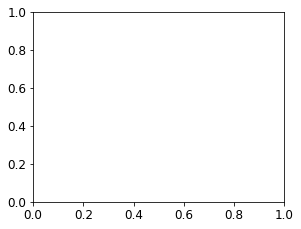

In [10]:
plot_row(results, prefix='baselines', datasets=['celeba'],
        # methods=['single_task', 'cosmos_orig', 'linear_scalarization', 'calibrated_linear_scalarization']
         methods=['single_task', 'linear_scalarization']
        )

In [39]:
isinstance([1,2], list)

True

In [6]:
results['celeba']['cosmos_orig']

KeyError: 'cosmos_orig'

In [13]:
rand = np.random.rand(4,5)

In [15]:
rand

array([[0.76971038, 0.22571083, 0.89411608, 0.96852937, 0.56946611],
       [0.20862544, 0.38963795, 0.73786994, 0.75414663, 0.31087956],
       [0.64088266, 0.64160727, 0.40779501, 0.04913566, 0.20243111],
       [0.3473308 , 0.71131234, 0.67087917, 0.79356064, 0.94976201]])

In [16]:
for r in rand[1:]:
    print(r)

[0.20862544 0.38963795 0.73786994 0.75414663 0.31087956]
[0.64088266 0.64160727 0.40779501 0.04913566 0.20243111]
[0.3473308  0.71131234 0.67087917 0.79356064 0.94976201]
